Elements for a CO WD type Ia supernova

H1 $\to$ 1, 1, 1.00727 (accreted from companion) \
H2 $\to$ 2, 1, 2.0140  (accreted from companion) \
He3 $\to$ 3, 2, 3.01603 (accreted from companion) \
He4 $\to$ 4, 2, 4.00260 (accreted from companion) \
C12 $\to$ 12, 6, 12. (CNO ) \
N14 $\to$  14, 7, 14.007 (CNO) \
O16 $\to$ 16, 8, 15.994 (CNO) \
Ne20 $\to$ 20, 10, 20.1797 (alpha network) \
Mg24 $\to$ 24, 12, 24.3050 (alpha network) \
Si28 $\to$ 28, 14, 27.976 (alpha network) \
S32 $\to$ 32, 16, 31.972 (alpha network) \
Ar36 $\to$ 36, 18, 35.967 (alpha network) \
Ca40 $\to$ 40, 20, 39.962 (alpha network) \
Ti44 $\to$ 44, 22, 43.9596 (alpha network) \
Cr48 $\to$ 48, 24, 47.9540 (alpha network) \
Fe52 $\to$ 52, 26, 51.9481 (alpha network) \
Fe54 $\to$ 54, 26, 53.939 (electron capture) \
Ni56 $\to$ 56, 28, 55.940 (alpha network) \
Co56 $\to$ 56, 27, 55.9398393 (decay of 56Ni) \
Fe56 $\to$ 56, 26, 55.9349 (decay of 56Co) \
Fe57 $\to$ 57, 26, 56.9353 (decay of 58Fe) \
Fe58 $\to$ 58, 26, 57.9332 (neutron capture) \
Ni58 $\to$ 58, 28, 57.9353429 (neutron capture) 

In [226]:
file_path = '/Users/anirbandutta/Documents/SNEXP/TypeIa_Models/'

In [227]:
import abc
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from matplotlib.ticker import MultipleLocator
import seaborn as sns
import pandas as pd
%config InlineBackend.figure_format = 'retina'

plt.rcParams['axes.linewidth'] = 3
plt.rcParams['axes.labelsize'] = 30
plt.rcParams['axes.titlesize'] = 25
plt.rcParams['xtick.labelsize'] = 25
plt.rcParams['ytick.labelsize'] = 25
plt.rcParams['legend.fontsize'] = 20
plt.rc('font',family='Times New Roman')

In [228]:
# Global constants
km_cm = 1e5            # km to cm
Msun = 1.9884e33       # g
A = 7.5646e-15
kB = 1.381e-16         # erg / K

In [229]:
class elements:
    
    def __init__(self, A, Z, weight, repr):
        
        '''
        A: maass number
        Z: atomin number
        weight: atomic weight (in amu)
        
        '''
        
        self.A = A
        self.Z = Z
        self.weight = weight
        self.repr = repr
        
    def __repr__(self):
        
        '''
        representation object
        
        '''
        
        return '%s: A=%d, Z=%d, weight=%.3f' %(self.repr, self.A,
                                              self.Z, self.weight)
    
    

class Layers:
    
    def __init__(self, abundances):
        
        '''
        abundances: Abundances of the layers. Any set of abundance for a layer will be normalized.
        
        '''
        
        self.normalization = sum(abundances.values())
        self.abundances = {key:abundances[key]/self.normalization 
                          for key in abundances}
        
    def __repr__(self):
        
        s = 'Layer:\n'
        return s + '\n'.join(['\t%s abundance = %.3e' % (key, self.abundances[key])
                             for key in self.abundances])
    
    
class exp_density_profile:
    
    '''
    An exponential density profile.
    
    '''
    
    def __init__(self, ke, mass):
        
        self.ke = ke         # erg
        self.mass = mass     # msun
        self.ve = np.sqrt(ke / (6.0 * mass * Msun)) / km_cm
        
    
    def __call__(self, v):
        
        z = v / self.ve
        
        return 1 - 0.5 * (np.exp(-z) * (2 + 2*z + z**2))
    
    
    
class Flat_profile:
    
    '''
    A flat density profile.
    
    '''
    
    def __init__(self, vt):
        self.vt = vt
        
    def __call__(self, v):
        
        return v / self.vt
    

    
class Stratified_Atmosphere:
    
   

    def __init__(self, layers, masses, profile, nzones=100, v_outer=4e4,
                texp=86400., thermal_energy=0., thermal_profile=None):
        
        # state 
        self.layers = layers
        self.profile = profile
        self.masses = masses
        self._thermal_energy = thermal_energy
        if thermal_profile is not None:
            self.thermal_energy_profile = thermal_profile
        else:
            self.thermal_energy_profile = Flat_profile(v_outer)
        
        
        # parameters 
        
        self._nzones = nzones
        self._v_outer = v_outer
        self._texp = texp
        
    
    def velocity(self, kind='average'):
        
        """
        Zone radial velocities (km /s).
    
        """
        
        if kind == 'outer':
            
            return (self._v_outer / self._nzones) * np.arange(1, self._nzones + 1)
        
        else:
            boundary_vels = np.concatenate((np.asarray([0.]),
                                          self.velocity(kind='outer')))
            
            if kind == 'average':
                
                return (boundary_vels[:-1] + boundary_vels[1:]) / 2.
            
            elif kind == 'inner':
                
                return boundary_vels[:-1]
            
            else:
                
                return ValueError('kind must be one of outer, inner, average')
            
    @property
    def nzones(self):
        return self._nzones
    
    @property
    def texp(self):
        return self._texp
    
    
    @property 
    def interior_mass(self):
        
        vo = self.velocity(kind='outer')
        return self.profile(vo) * sum(self.masses)
    
    @property
    def shell_mass(self):
        
        im = self.interior_mass
        return np.concatenate(([im[0]], im[1:] - im[:-1]))
    
    @property
    def vol_cm3(self):
        vo = self.velocity(kind='outer')
        vi = self.velocity(kind='inner')
        vol = (4 * np.pi * (vo**3 - vi**3) * km_cm**3 * self._texp**3) / 3
        
        return vol
    
    @property
    def vol_km3(self):
        return self.vol_cm3 / km_cm**3
    
    @property
    def rho_Msun_km3(self):
        return self.shell_mass / self.vol_km3
    
    @property
    def rho_g_cm3(self):
        return self.rho_Msun_km3 * Msun / km_cm**3
    
    @property
    def spec_mass(self):
        return self.shell_mass[:, None] * self._comp
    
    
    def layer_mass(self, layerind, i):
        
        return self.shell_mass[i]  * self.frac[i, layerind]
    
    
    def total_ejecta_mass(self):
        
        return self.interior_mass[-1]
    
    @property
    def interior_thermal_energy(self):
        
        vo = self.velocity(kind='outer')
        return self._thermal_energy * self.thermal_energy_profile(vo)
    
    @property
    def shell_thermal_energy(self):
        ie = self.interior_thermal_energy
        return np.concatenate(([ie[0]], ie[1:] - ie[:-1]))
    
    @property
    def TK(self):
        return (self.shell_thermal_energy / A / self.vol_cm3)**0.25
    
    @property
    def thermal_energy(self):
        return self.shell_thermal_energy[-1]
    
    
    @property
    def comp(self):
        return self._comp
        
    def Atmos(self):
        
        # grid 
        
        self.vgrid_outer = self.velocity(kind='outer')
        self.vgrid_inner = self.velocity(kind='inner')
        self.vgrid_avg = self.velocity(kind='average')
        
        # enumerate unique elements in the atmosphere
        
        spec = []
        for layer in self.layers:
            spec += list(layer.abundances.keys())
            
        self._spec = sorted(set(spec), key = lambda x: x.weight)[::-1]
        
        # initialize composition array
        
        self._comp = np.zeros((self._nzones, self.nspec))
        self.frac = np.zeros((self._nzones, len(self.layers)))
        
        radii = [0]
        for j in range(len(self.layers)):
            radii.append(radii[j] + self.masses[j])
            
        self.radii = np.asarray(radii[1:])
        self.edge_shells = list(map(self.interior_mass.searchsorted, self.radii))

        
        for i in range(self._nzones):   # nzones = 100
            sm = self.shell_mass[i]
            isedge = np.asarray(self.edge_shells[:-1]) == i
            nedge = isedge[isedge].size
            
            if nedge == 0:
                bounds = [0] + self.edge_shells
                for j in range(len(self.layers)):
                    if bounds[j] <= i <= bounds[j+1]:
                        self.frac[i, j] = 1.
                        self._comp[i] = self._abun(self.frac[i]) 
                        
            else:
                
                ending, kmax = np.argwhere(isedge)[[0, -1], 0]
                starting = kmax + 1
                
                prev_mass = sum([self.layer_mass(ending, l)
                                for l in range(0, i)])
                
                remaining_mass = self.masses[ending] - prev_mass
                
                self.frac[i, ending] = remaining_mass / sm
                
                for k in range(ending+1, starting)[::-1]:
                    self.frac[i, k] = self.masses[k] / sm
                self.frac[i, starting] = 1 - sum(self.frac[i, ending:starting])
                self._comp[i] = self._abun(self.frac[i])
                
        
    def _indexof(self, element):
        
        return self.spec.index(element)
 
    @property
    def spec(self):
        return self._spec
    
    
    @property
    def nspec(self):
        return len(self.spec)
    
    def _abun(self, frac):
        
        result = np.zeros(self.nspec)
        for layer, frac in zip(self.layers, frac):
            for elem in layer.abundances:
                result[self._indexof(elem)] += layer.abundances[elem] * frac
        
        return result
        
    
    
    def plot_ejecta(self, thermal=False):
        
        if thermal:
            fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(20, 20))
        else:
            fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15, 15))
            
            
        sns.set_style('ticks')
        
        colors = ['#e63946', '#48cae4', '#006d77', '#9d4edd', '#c44536',
                  '#ff7f51', '#a4ac86', '#90be6d', '#b298dc', '#0466c8']
        
        ls = ['--']
        
        styles = [{'color':c, 'ls':linestyle} for linestyle in ls for c in colors]
        
        ele = [elem.repr for elem in self.spec]
        v_avg = self.velocity(kind='average')
        
        # Plot mass fraction versus velocity
        
        for row, name, style in zip(self.comp.T, ele, styles):
            ax[0, 0].semilogy(v_avg, row, label=name, **style, lw=2.0)
            ax[0, 0].set_ylabel(r'Mass Fraction [X]')
            ax[0, 0].set_ylim(1e-3, 1.)
            handles, labels = ax[0, 0].get_legend_handles_labels()
            ax[0, 0].set_xlabel(r'Velocity [km $\rm s^{-1}$]')
            
            
        # Plot mass fraction versus interior mass
        
        for row, name, style in zip(self.comp.T, ele, styles):
            ax[0, 1].semilogy(self.interior_mass, row, label=name, **style, lw=2.0)
            ax[0, 1].set_xlabel(r'Interior Mass $\rm [M_{\odot}]$')
            ax[0, 1].set_ylim(1e-3, 1.)
            
            
        ax[1, 0].semilogy(v_avg, self.rho_g_cm3, color='navy')
        ax[1, 0].set_ylabel(r'$\rm \rho~[g~cm^{-3}]$')
        ax[1, 0].set_xlabel(r'Velocity [km $\rm s^{-1}$]')
        
        ax[1, 1].semilogy(self.interior_mass, self.rho_g_cm3, color='navy')
        ax[1, 1].set_xlabel(r'Interior Mass $\rm [M_{\odot}]$')
        
        if thermal:
            ax[2, 0].semilogy(v_avg, self.TK)
            ax[2, 0].set_ylabel(r'T (K)')
            ax[2, 0].set_xlabel(r'Velocity [km $\rm s^{-1}$]')
            
            ax[2, 1].semilogy(self.interior_mass, np.cumsum(self.shell_thermal_energy))
            ax[2, 1].set_xlabel(r'Interior Mass $\rm [M_{\odot}]$')
            ax[2, 1].set_ylabel(r'Total thermal energy (erg)')
        
        for axis in ax.ravel():
            axis.minorticks_on()
            axis.tick_params(axis = 'both', which = 'major', direction = 'in', 
                   length = 16, width = 1.5, labelsize = 20)
            axis.tick_params(axis = 'both', which = 'minor', direction = 'in', 
                   length = 8, width = 0.8, labelsize = 20)
        
        for axis in ax[:, 0]:
            axis.set_xscale('log')
            
        ele_mass = self.spec_mass.sum(axis=0)
        newlabels = [label + ' ' + r'$(%.3f~M_{\odot})$'% mass for label, mass \
                    in zip(labels, ele_mass)]
        
        fig.tight_layout()
        fig.subplots_adjust(top=0.9)
        fig.legend(handles, newlabels, loc='upper center', ncol=5, )
        sns.despine()
        
        
class model_density:
    
    def __init__(self, file_name):
        
        '''
        file_name : Density file from HESMA database.
        2 columns: first column gives the velocity in km/s (specified at the centre of a radial shell), 
        second column gives density in g/cm^3. For models that leave a bound remnant, 
        the profile extends only over the ejecta. The density is computed as a spherical average over the 
        hydrodynamics data; thus, it is a good description for the density at the corresponding radius. 
        It may, however, be slightly inconsistent when integrating to obtain a mass.
        '''
        
        column_names = ['velocity', 'density']        # km/sec, gm/cm^3
        self.density_df = pd.read_csv(file_name, sep='\s+', names=column_names, engine='python', 
                                      comment='#', skiprows=1)
        
    def get_model(self):
        
        velocity = np.array(self.density_df['velocity'])
        density = np.array(self.density_df['density'])
        
        return velocity, density
            
            
    def plot_params(self, ax, ml_x, mil_x, ml_y, mil_y, invert=False):
    
        '''
        Remarks: Plotting parameters
        ax: axis object
        ml_x: major locator 'x'
        mil_x: minor locator 'x'
        ml_y: major locator 'y'
        mil_y: minor locator 'y'
        invert: Bool for the y-axis to be inverted 
    
        '''
    
        if invert:
            ax.invert_yaxis()
        
        ax.xaxis.set_ticks_position('bottom')
        ax.yaxis.set_ticks_position('left')
        ax.tick_params(axis = 'both', which = 'major', direction = 'in', length = 12, width = 2.0, labelsize = 12)
        ax.tick_params(axis = 'both', which = 'minor', direction = 'in', length = 6, width = 1.2, labelsize = 12)
        ax.xaxis.set_major_locator(MultipleLocator(ml_x))
        ax.xaxis.set_minor_locator(MultipleLocator(mil_x))
        ax.yaxis.set_major_locator(MultipleLocator(ml_y))
        ax.yaxis.set_minor_locator(MultipleLocator(mil_y))
        
        
    def homologous_expansion(self, rho_ref, t_ref, t_exp):
        
        '''
        rho_ref : rho(v) at time explosion time t0.
        t_ref: reference explosion epoch in days.
        t_exp: time since explosion when density is being calculated in days.
        
        returns: rho
        '''
        
        rho = rho_ref * (t_ref / t_exp)**3
        
        return rho
    

    def uniform_density(self, rho_ref, t_ref, t_exp):
        
        '''
        rho_ref : rho(v) at time explosion time t0.
        t_ref: reference explosion epoch in days.
        t_exp: time since explosion when density is being calculated in days.
        
        returns: rho
        '''
        
        rho = rho_ref * (t_ref / t_exp)**3
        
        return rho
    
    
    def power_law(self, rho_0, t_ref, t_exp, v, v0, n=-2):
        
        '''
        rho_ref : rho(v) at time explosion time t0.
        t_ref: reference explosion epoch in days.
        t_exp: time since explosion when density is being calculated in days.
        v: velocity in km/s.
        v0: scale velocity in km/s.
        
        returns: rho
        '''
        
        rho_ref = rho_0 * (v / v0)**n
        
        rho = rho_ref * (t_ref / t_exp)**3
        
        return rho
    
    
    def exponential(self, rho_0, t_ref, t_exp, v, v0):
        
        '''
        rho_ref : rho(v) at time explosion time t0.
        t_ref: reference explosion epoch in days.
        t_exp: time since explosion when density is being calculated in days.
        
        returns: rho
        '''
        
        rho_ref = rho_0 * np.exp(- v / v0)
        
        rho = rho_ref * (t_ref / t)**3
        
        return rho
    
    
    def plot_model_density(self, model_name, log_axis=True):
        
        
        '''
        model_name: name of the model whose density profile is being plotted.
        
        '''
        
        fig_app = plt.figure(figsize = (5, 5), facecolor='white')
        ax = fig_app.add_subplot(111)
        plt.rcParams['axes.linewidth'] = 3
        self.plot_params(ax, ml_x = 5000, mil_x = 1000, ml_y = 1, mil_y = 0.1, invert=False)
        legend_properties = {'size':15, 'weight':'book'}
        ax.plot(self.density_df['velocity'], self.density_df['density'], 'r--', label=model_name)
        if log_axis:
            ax.set_yscale("log")
            ax.set_xscale("log")
    
        ax.set_xlabel(r'$\rm Velocity\ [km/s]$', fontsize=20)
        ax.set_ylabel(r'$\rm Density\ [g/cm^{3}]$', fontsize=20)
        ax.legend(fontsize=12, borderaxespad=3)
        ax.set_title("Density vs Velocity", fontsize=20) 
        
        
class BoxCarMixer:
    
    def __init__(self, winsize, nreps=50, mass_min=0., mass_max=np.inf):
        
        self.winsize = winsize
        self.nreps = nreps
        self.mass_min = mass_min
        self.mass_max = mass_max
        
        
    def Mixing(self, atm):
        
        # coordinate systems to transform between
        m = np.concatenate(([0.], atm.interior_mass))
        v = np.concatenate(([0.], atm.velocity(kind='outer')))
        
        # interpolate m(v)
        m_v = interp1d(v, m, kind='linear')
        
        # compute the massses that correspond to v_average
        m_av = m_v(atm.velocity(kind='average'))
        
        # Calculate the number of points to use on the grid
        n = int(2 * (m_av[-1] - m_av[0]) / self.winsize)
        atm.Atmos()
        composition = atm.comp
        # Uniform gridding in Lagrangian space
        m_unif = np.linspace(m_av[0], m_av[-1], n)
        
        # indices of the m_unif zones that corresponds to the 
        # mixing zone.
        
        ix_min = m_unif.searchsorted(self.mass_min)
        ix_max = m_unif.searchsorted(self.mass_max)
        
        for j, row in enumerate(composition.T):
            
            c_m = interp1d(m_av, row, kind='linear')
            c = c_m(m_unif)
            c_mix = c[ix_min:ix_max]
            mixing_series = pd.Series(c_mix)
            
            for i in range(self.nreps):
                mixing_series = mixing_series.rolling(window=2, min_periods=1, center=True).mean()
                
            c[ix_min:ix_max] = mixing_series
            c_m = interp1d(m_unif, c, kind='linear')
            
            composition.T[j] = c_m(m_av)
            
        return composition
    
    
    def plot_ejecta(self, atm):
        
        fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15, 15))
        sns.set_style('ticks')
        
        colors = ['#e63946', '#48cae4', '#006d77', '#9d4edd', '#c44536',
                  '#ff7f51', '#a4ac86', '#90be6d', '#b298dc', '#0466c8']
        
        ls = ['--']
        
        styles = [{'color':c, 'ls':linestyle} for linestyle in ls for c in colors]
        
        ele = [elem.repr for elem in atm.spec]
        v_avg = atm.velocity(kind='average')
        
        # Plot mass fraction versus velocity
        comp = self.Mixing(atm)
        
        for row, name, style in zip(comp.T, ele, styles):
            ax[0, 0].semilogy(v_avg, row, label=name, **style, lw=2.0)
            ax[0, 0].set_ylabel(r'Mass Fraction [X]')
            ax[0, 0].set_ylim(1e-3, 1.)
            handles, labels = ax[0, 0].get_legend_handles_labels()
            ax[0, 0].set_xlabel(r'Velocity [km $\rm s^{-1}$]')
            
        # Plot mass fraction versus interior mass
        
        for row, name, style in zip(comp.T, ele, styles):
            ax[0, 1].semilogy(atm.interior_mass, row, label=name, **style, lw=2.0)
            ax[0, 1].set_xlabel(r'Interior Mass $\rm [M_{\odot}]$')
            ax[0, 1].set_ylim(1e-3, 1.)
            
            
        ax[1, 0].semilogy(v_avg, atm.rho_g_cm3, color='navy')
        ax[1, 0].set_ylabel(r'$\rm \rho~[g~cm^{-3}]$')
        ax[1, 0].set_xlabel(r'Velocity [km $\rm s^{-1}$]')
        
        ax[1, 1].semilogy(atm.interior_mass, atm.rho_g_cm3, color='navy')
        ax[1, 1].set_xlabel(r'Interior Mass $\rm [M_{\odot}]$')
        
        for axis in ax.ravel():
            axis.minorticks_on()
            axis.tick_params(axis = 'both', which = 'major', direction = 'in', 
                   length = 16, width = 1.5, labelsize = 20)
            axis.tick_params(axis = 'both', which = 'minor', direction = 'in', 
                   length = 8, width = 0.8, labelsize = 20)
            
        ele_mass = atm.spec_mass.sum(axis=0)
        newlabels = [label + ' ' + r'$(%.3f~M_{\odot})$'% mass for label, mass \
                    in zip(labels, ele_mass)]
            
        #for axis in ax[:, 1]:
        #    axis.set_xscale('log')
            
            
        fig.tight_layout()
        fig.subplots_adjust(top=0.9)
        fig.legend(handles, newlabels, loc='upper center', ncol=5, )
        sns.despine()
        

def write_sedona_model(atm, compos, outfile):
    
    with open(outfile, 'w') as f:
        
        f.write('1D_sphere SNR\n')
        f.write('%d %f %f %d\n' % (atm.nzones, atm.velocity(kind='inner')[0] * km_cm,
                                  atm.texp, atm.nspec))
        f.write(' '.join(['%d.%d' % (elem.Z, elem.A) for elem in atm.spec]) + '\n')
        v = atm.velocity(kind='outer') * km_cm
        
        for i in range(atm.nzones):
            rho = atm.rho_g_cm3[i]
            T = atm.TK[i]
            comps = compos[i].round(3)
            line = map(str, [v[i], rho, T] + comps.tolist())
            f.write(' '.join(line) + '\n')
        
    f.close()

In [230]:
# A supernova atmosphere

# Unburned 

C12 = elements(12, 6, 12., 'C12')
O16 = elements(16, 8, 15.994, 'O16')
Ne20 = elements( 20, 10, 20.1797, 'Ne20')

# IME

Mg24 = elements(24, 12, 24.3050, 'Mg24')
Si28 = elements(28, 14, 27.976, 'Si28')
S32 = elements(32, 16, 31.972, 'S32')
Ca40 = elements(40, 20, 39.962, 'Ca40')

# IGE 

Fe54 = elements(54, 26, 53.939, 'Fe54')
Ni58 = elements(58, 28, 57.9353429, 'Ni58')

# Ni56

Ni56 = elements(56, 28, 55.940, 'Ni56')

In [231]:
# Ejecta Layers

#co = Layers({C12: 0.45, O16: 0.5, Ne20: 0.05})

#ime = Layers({Mg24: 0.1, Si28: 0.50, S32: 0.3, Ca40: 0.10})

#ige = Layers({Fe54: 0.5, Ni58: 0.5})

#ni = Layers({Ni56: 1.0})

layer1 = Layers({C12: 0.45, O16:0.5, Ne20: 0.05})
layer2 = Layers({C12: 0.05, O16: 0.1, Mg24: 0.05, Si28: 0.50, S32: 0.2, Ca40: 0.10})
layer3 = Layers({Ni56: 0.8, C12: 0.1, O16: 0.05, Si28: 0.05})
layer4 = Layers({Fe54: 0.3, Ni58: 0.2, Si28: 0.05, O16: 0.1, C12: 0.01, Ni56: 0.34})

In [232]:
layers = [layer4, layer3, layer2, layer1]
# 0.2 solar mass of ige, 0.6 solar mass of 56Ni, 0.4 solar mass of ime, 0.2 solar mass of CO
layermasses = [0.2, 0.6, 0.4, 0.2]

In [233]:
mass = 1.4         # in solar masses
KE = 1e51          # in erg

profile = exp_density_profile(KE, sum(layermasses))
stra = Stratified_Atmosphere(layers, layermasses, profile, thermal_energy=1e50, thermal_profile=profile)

In [234]:
mixer = BoxCarMixer(winsize=0.02)

In [235]:
mixedatm =  mixer.Mixing(stra)

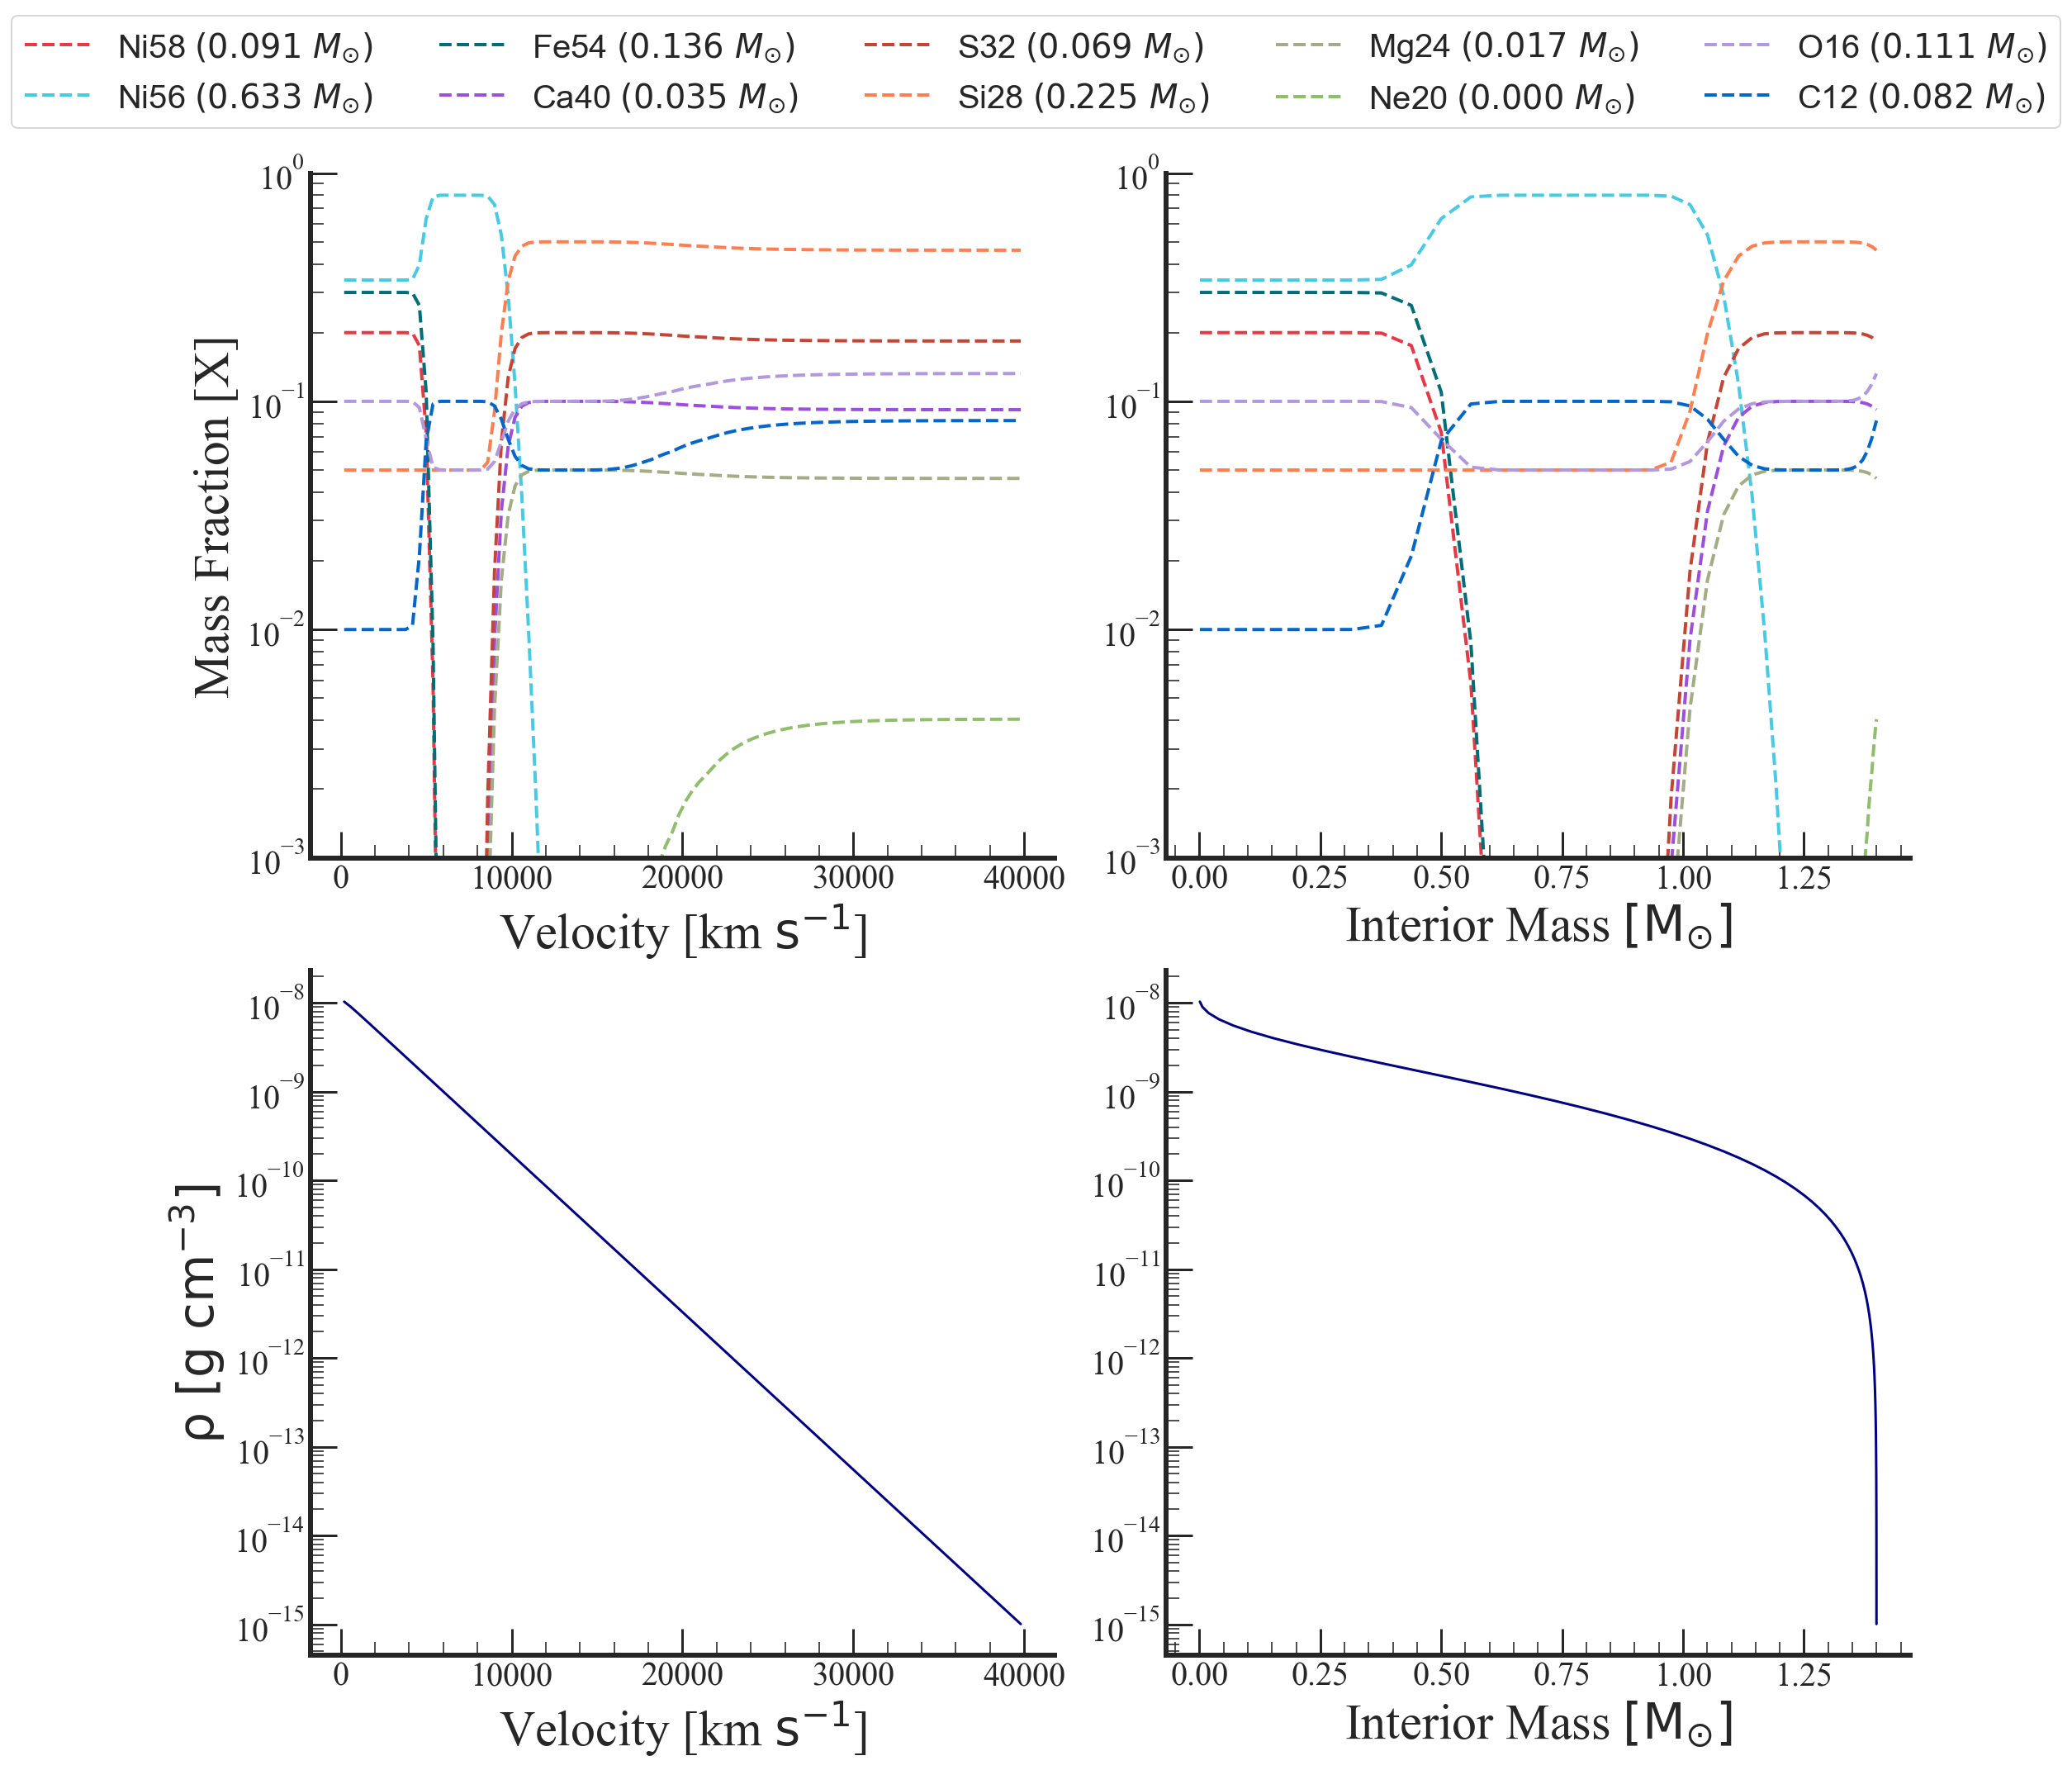

In [236]:
mixer.plot_ejecta(stra)

In [237]:
stra.Atmos()

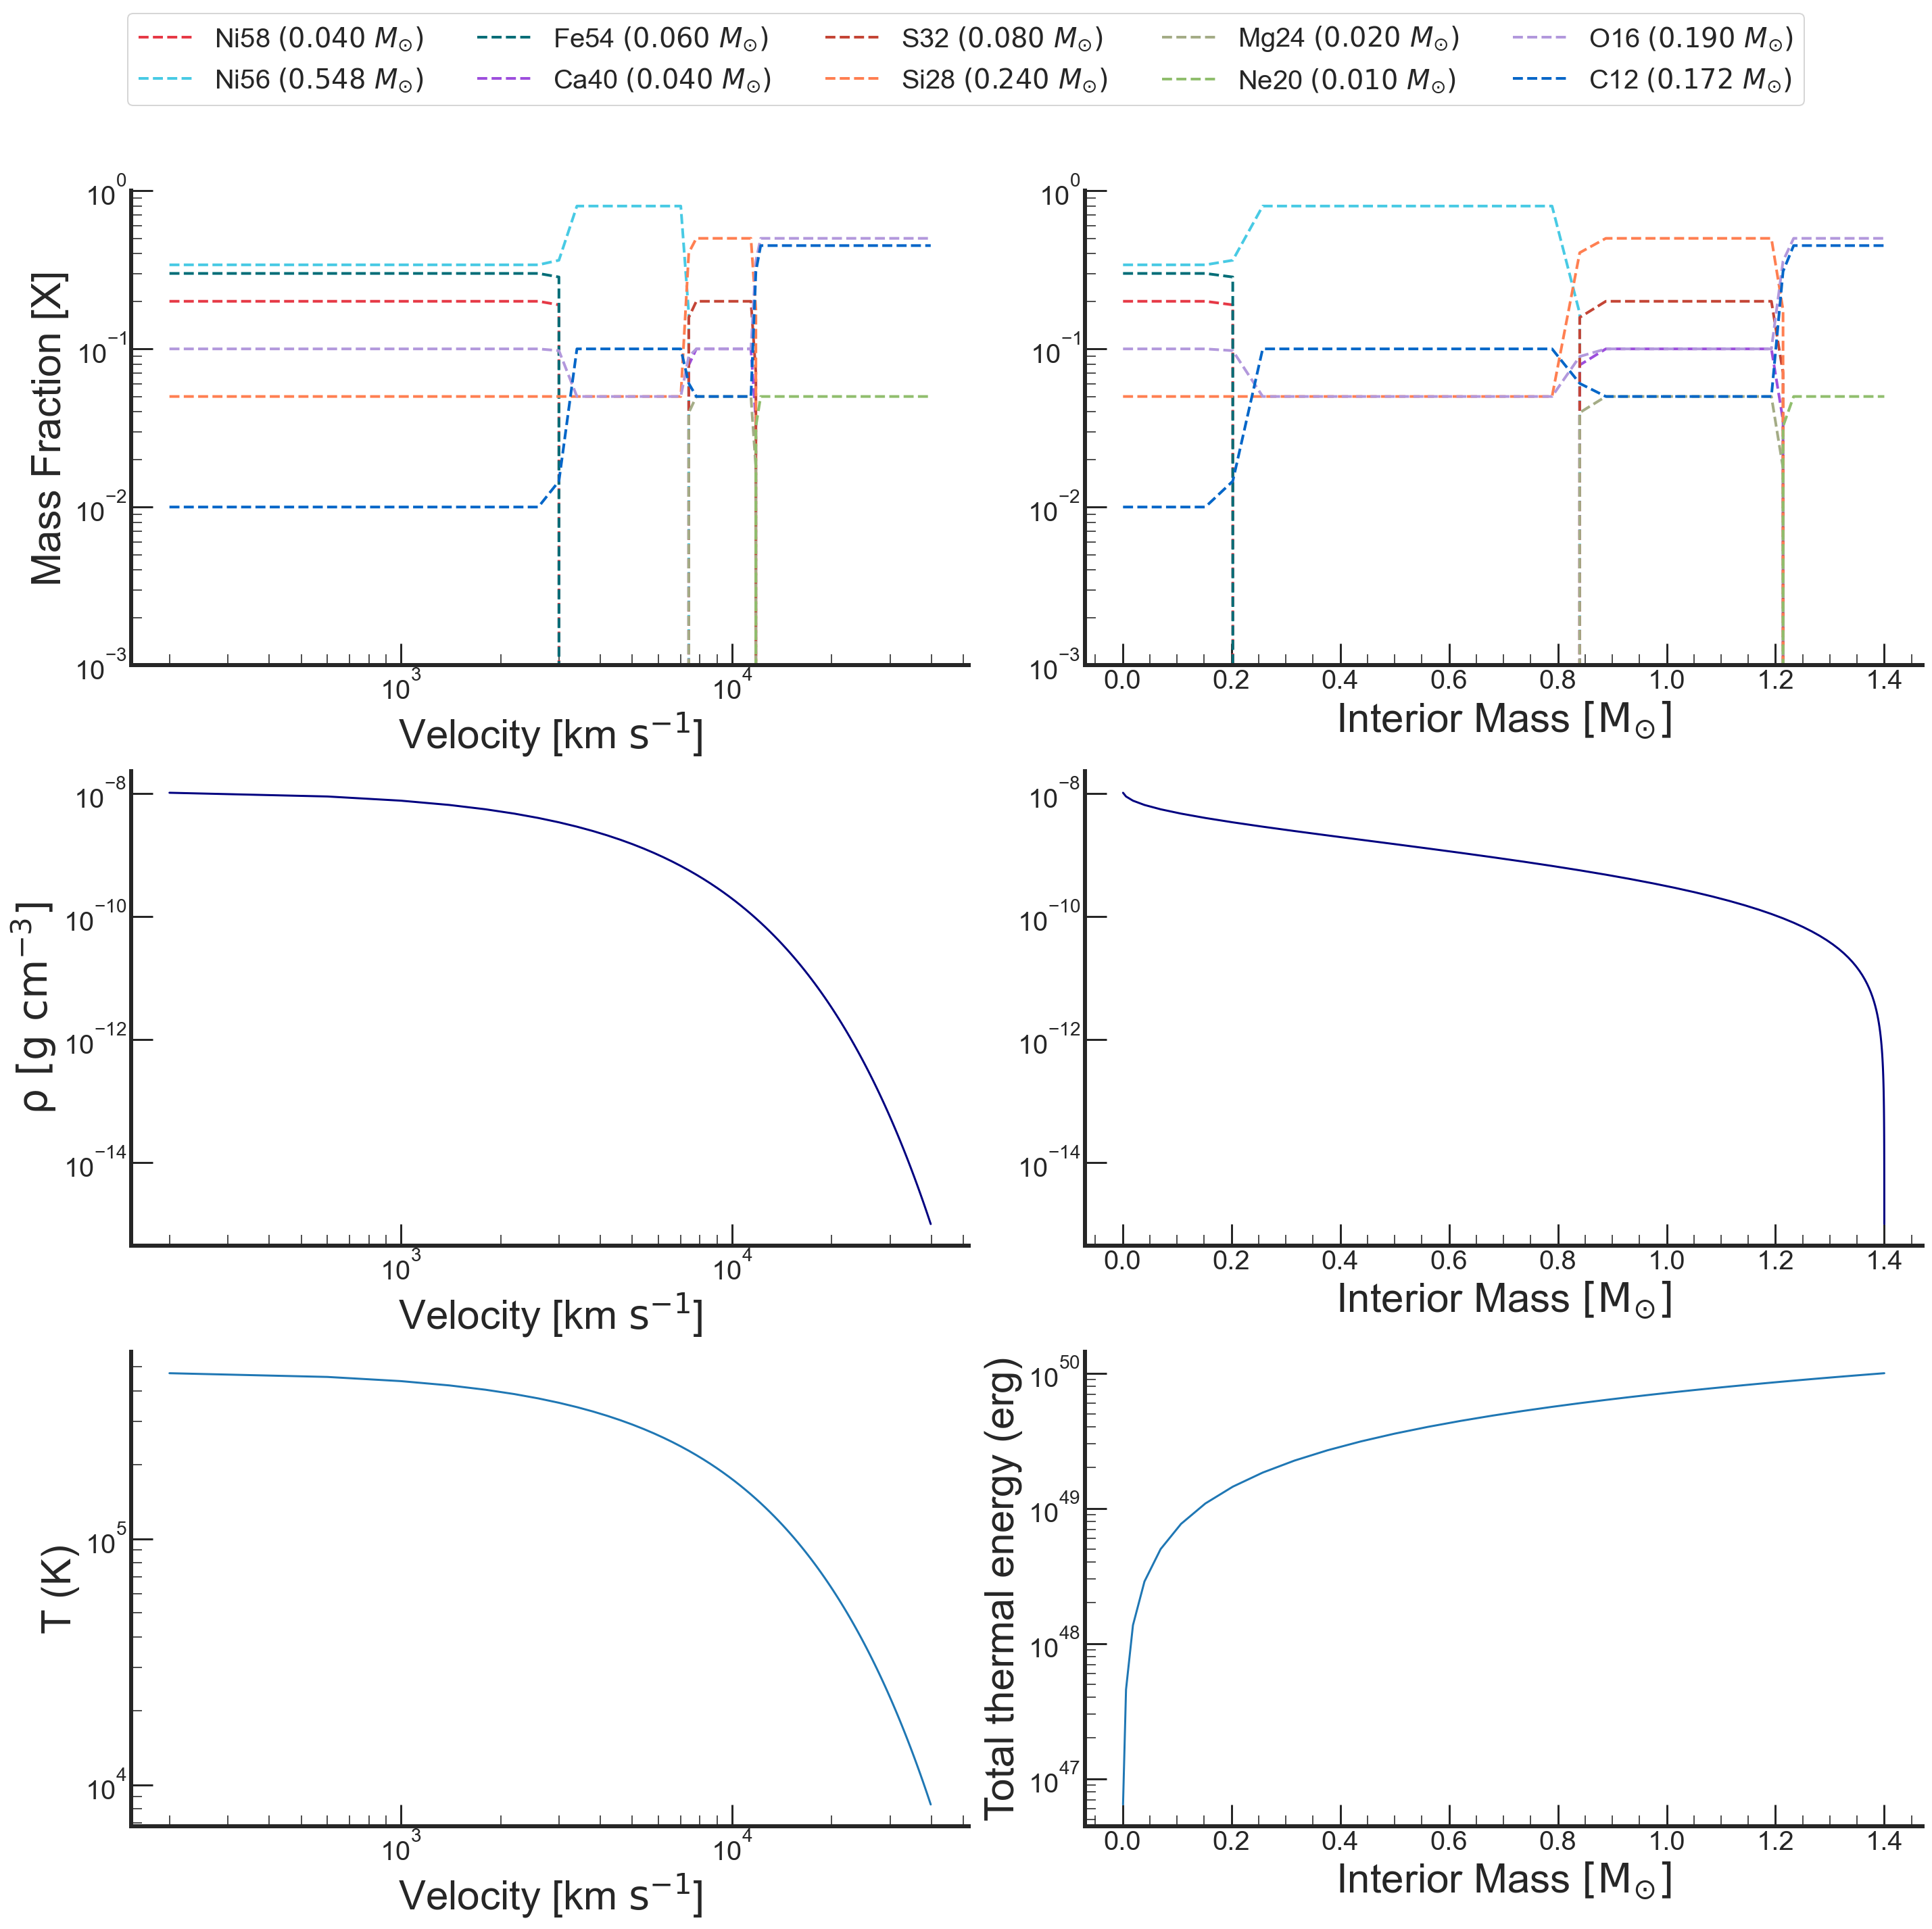

In [238]:
stra.plot_ejecta(thermal=True)

In [239]:
write_sedona_model(atm=stra, compos=mixedatm, outfile='/Users/anirbandutta/Documents/SNEXP/Sedona_Run_Models/model1.out')

In [240]:
#profile = exp_density_profile(1e51, 1.4)

In [241]:
# density_file = file_path + 'merger_2012_11_09_density.dat' 
# density = model_density(density_file)
# density.plot_model_density(model_name='Violent')

In [242]:
# velocity, density_merger = density.get_model()

In [243]:
# density_merger_1d = density.homologous_expansion(density_merger, 0.001157, 1)

In [244]:
# plt.plot(velocity, density_merger_1d, 'r--')
# plt.plot(v_avg, density_exp, 'b--')
# plt.xscale('log')
# plt.yscale('log')

In [245]:
# fig = plt.figure(figsize=(10, 10))

# masses = [1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0]
# KE = [1.0e51, 1.2e51, 1.4e51, 1.6e51, 1.8e51]

# #masses = [1.9]
# #KE = [2.0e51]

# for i in range(len(masses)):
#     for j in range(len(KE)):
#         profile = exp_density_profile(KE[j], masses[i])
#         stra = Stratified_Atmosphere(layers, layermasses, profile)
#         v_avg = stra.velocity(kind='average')
#         density_exp = stra.rho_g_cm3
#         plt.plot(v_avg, density_exp, ls='--', lw=2.0, label=r'M=%f + KE=%.2e'%(masses[i], KE[j]))
    
    
# plt.plot(velocity, density_merger_1d, 'r--')
# plt.xscale("log")
# plt.yscale("log")
# #plt.legend();